In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine  # Seeds нет в sklearn, но есть аналог — загрузим вручную
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
import xgboost as xgb
from catboost import CatBoostClassifier

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
column_names = [
    "area", "perimeter", "compactness", "length_of_kernel",
    "width_of_kernel", "asymmetry_coefficient", "length_of_groove", "class"
]

data = pd.read_csv(url, sep=r'\s+', names=column_names, engine='python')
data


,area,perimeter,compactness,length_of_kernel,width_of_kernel,asymmetry_coefficient,length_of_groove,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


In [5]:
data = data.dropna()
data

,area,perimeter,compactness,length_of_kernel,width_of_kernel,asymmetry_coefficient,length_of_groove,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


строк с пропущенными згаченяими нет.

In [9]:
X = data.drop('class', axis=1)
y = data['class'].astype(int)


# перекодируем классы 1,2,3 → 0,1,2, т.к. XGBoost ожидает метки классов в виде последовательных целых чисел, начинающихся с 0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['class'])

# у нас многоклассовая классификация с 3 типами таргетов
print("Классы:", np.unique(y))

Классы: [0 1 2]


In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

In [11]:
models = {}

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
models['Decision Tree'] = dt

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
models['Random Forest'] = rf

ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)
models['AdaBoost'] = ada

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model

cb_model = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
cb_model.fit(X_train, y_train)
models['CatBoost'] = cb_model

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:54:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [12]:
print("\n=== Точность моделей на тестовой выборке ===")
accuracies = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"{name}: {acc:.4f}")


=== Точность моделей на тестовой выборке ===
Decision Tree: 0.8889
Random Forest: 0.9206
AdaBoost: 0.8413
XGBoost: 0.8730
CatBoost: 0.9048


In [13]:
best_model_name = max(accuracies, key=accuracies.get)
best_model = models[best_model_name]
print(f"\nЛучшая модель: {best_model_name} (accuracy = {accuracies[best_model_name]:.4f})")


Лучшая модель: Random Forest (accuracy = 0.9206)


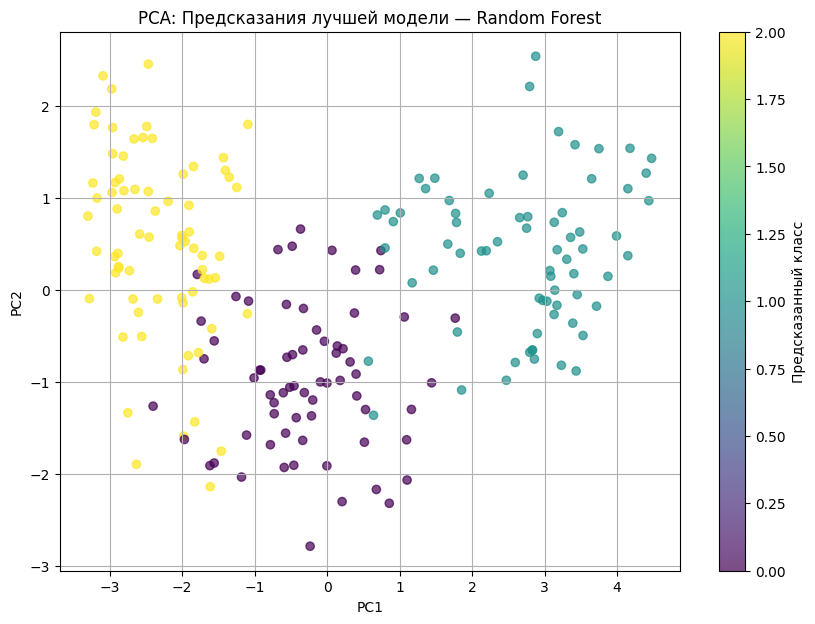

In [14]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

y_pred_full = best_model.predict(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_full, cmap='viridis', alpha=0.7)
plt.title(f'PCA: Предсказания лучшей модели — {best_model_name}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='Предсказанный класс')
plt.grid(True)
plt.show()